<a href="https://colab.research.google.com/github/arijitar/Diabetic-Retinopathy-detection/blob/main/Copy_of_Optimized_InceptionV3_By_Using_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Loading all the neccessary libraries as per the requirement i.e.
# 1. Reading the files = os
# 2. Image Processing  = cv2
# 3. Deep Learning  = tensorflow
# 4. Splitting the data & Endcoding the Labels = sklearn
# 5. For cleaning memory = gc
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2DTranspose, Conv2D, LeakyReLU, MaxPooling2D, Dropout, concatenate, GlobalAveragePooling2D, Cropping2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_size = 150 # By deafult image size is (299,299,3) but due to limited RAM and GPU provided by the google colab it crashes.
# Therefore to overcome the problem of GPU crashes we have reduced the size of an image i.e. (150,150,3)

path = '/content/drive/MyDrive/DataSet' # It points to the original dataset path

image_type_folders = os.listdir(path) # stores the entire path to the dataset into this variable

print("Folders inside Dataset Folder = ",image_type_folders)

images = [] # Images list will store all the images
labels = [] # labels list will store "positve" & "negative" labels

for folder in image_type_folders:
    folder_path = os.path.join(path, folder)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (image_size, image_size)) # resize all the images
        images.append(img) # append the images into the images list
        labels.append(folder.strip().lower()) # append the folder names as labels i.e. positive & negative inside the labels list

Folders inside Dataset Folder =  ['positive', 'negative']


In [ ]:
images = np.array(images).astype('float32') / 255.0 # Converts the image list into numpy array and normalize all the pixel values into the range of (0-1)
labels = np.array(labels) # Make labels a Numpy array for easier processing

In [ ]:
# Separate images into positive and negative classes
positive_images = images[labels == 'positive']
negative_images = images[labels == 'negative']

In [ ]:
print("positive_images shape:", positive_images.shape)
print("negative_images shape:", negative_images.shape)

positive_images shape: (1750, 150, 150, 3)
negative_images shape: (1002, 150, 150, 3)


In [ ]:
latent_dim = 32 # Random noise vector size for the generator input

import math

base_size = math.ceil(image_size / 4) # It is used to reshape the noise into a feature map (Used in Generator)

def build_generator():
    return Sequential([
        Dense(64 * base_size * base_size, input_dim=latent_dim),
        LeakyReLU(0.2),
        Reshape((base_size, base_size, 64)),
        Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu'),
        Conv2DTranspose(32, 4, strides=2, padding='same', activation='relu'),
        Conv2D(3, kernel_size=3, padding='same', activation='sigmoid'),
        Cropping2D(cropping=((1,1), (1,1)))
    ])


#Takes noise → reshapes to image shape
#Conv2DTranspose: grows the image
# Final Conv2D: outputs a 3-channel (RGB) image
# Cropping2D: trims the final size to match exactly 150x150 image size

In [ ]:
def build_discriminator():
    model = Sequential([
        Input(shape=(image_size, image_size, 3)),
        Conv2D(64, 3, strides=2, padding='same'),
        LeakyReLU(0.2),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(0.0002), loss='binary_crossentropy')
    return model

# This is a binary classifier (real vs fake images).
# Compiles with binary crossentropy.

In [ ]:
def create_gan():
    generator = build_generator()
    discriminator = build_discriminator()
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    gan_output = discriminator(generator(gan_input))
    gan = Model(gan_input, gan_output)
    gan.compile(optimizer=Adam(0.0002), loss='binary_crossentropy')
    return generator, discriminator, gan

# Combines generator and discriminator.
# Freeze discriminator while training GAN.

In [ ]:
# Generates random noise vectors as fake inputs.
def generate_latent_points(latent_dim, n_samples):
    return np.random.randn(latent_dim * n_samples).reshape(n_samples, latent_dim)

In [ ]:
# Alternates training:

# Discriminator on real + fake images

# Generator via the GAN

# Prints progress every 5 epochs.

def train_gan(generator, discriminator, gan, dataset, epochs=10, batch_size=8):
    half = batch_size // 2

    if dataset.shape[0] < half:
        raise ValueError(f"Dataset size {dataset.shape[0]} is smaller than half batch size {half}")

    for epoch in range(epochs):
        idx = np.random.randint(0, dataset.shape[0], half)
        real_imgs = dataset[idx]
        real_labels = np.ones((half, 1))
        noise = generate_latent_points(latent_dim, half)
        fake_imgs = generator.predict(noise, verbose=0)
        fake_labels = np.zeros((half, 1))
        discriminator.train_on_batch(real_imgs, real_labels)
        discriminator.train_on_batch(fake_imgs, fake_labels)
        noise = generate_latent_points(latent_dim, batch_size)
        gan.train_on_batch(noise, np.ones((batch_size, 1)))
        if epoch % 5 == 0:
            print(f"Epoch {epoch} completed")


In [ ]:
# Train GANs & generate synthetic data in batches
# Uses the trained generator to create fake images.
# Cleans memory afterward (clear_session + gc.collect())
def generate_synthetic_images(class_images, n_samples):
    generator, discriminator, gan = create_gan()
    train_gan(generator, discriminator, gan, class_images, epochs=10, batch_size=8)
    synthetic = []
    for _ in range(n_samples // 250):
        noise = generate_latent_points(latent_dim, 250)
        synthetic.append(generator.predict(noise, verbose=0))
    tf.keras.backend.clear_session()
    gc.collect()
    return np.vstack(synthetic)

In [ ]:
# Creates fake positive and negative images (only if at least 4 real ones exist)
# Adds synthetic images to original dataset.
synthetic_positive = generate_synthetic_images(positive_images, 1750) if positive_images.shape[0] >= 4 else np.empty((0, image_size, image_size, 3))
synthetic_negative = generate_synthetic_images(negative_images, 2500) if negative_images.shape[0] >= 4 else np.empty((0, image_size, image_size, 3))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0 completed
Epoch 5 completed
Epoch 0 completed
Epoch 5 completed


In [ ]:
images = np.concatenate([images, synthetic_positive, synthetic_negative], axis=0)
labels = np.append(labels, ['positive'] * len(synthetic_positive) + ['negative'] * len(synthetic_negative))
# Updates label array to match new images.

In [ ]:
# checking the shape and how many data we have
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (7002, 150, 150, 3)
Labels shape: (7002,)


In [ ]:
# Encode labels
le = LabelEncoder()
labels = le.fit_transform(labels)
Y = to_categorical(labels)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images, Y, test_size=0.1, random_state=42)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6301, 150, 150, 3)
(701, 150, 150, 3)
(6301, 2)
(701, 2)


In [ ]:
# from tensorflow.keras.layers import BatchNormalization
# Inception Block

def inception_block(x, f1, f3r, f3, f5r, f5, totalFilters):
    b1 = Conv2D(f1, (1, 1), padding='same', activation='relu')(x)
    b2 = Conv2D(f3r, (1, 1), padding='same', activation='relu')(x)
    b2 = Conv2D(f3, (3, 3), padding='same', activation='relu')(b2)
    b3 = Conv2D(f5r, (1, 1), padding='same', activation='relu')(x)
    b3 = Conv2D(f5, (5, 5), padding='same', activation='relu')(b3)
    b4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    b4 = Conv2D(totalFilters, (1, 1), padding='same', activation='relu')(b4)
    return concatenate([b1, b2, b3, b4], axis=-1)

input_layer = Input(shape=(image_size, image_size, 3))
x = Conv2D(16, (3, 3), strides=(2, 2), padding='same', activation='relu')(input_layer)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
# x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = inception_block(x, 16, 16, 16, 4, 8, 8)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output_layer = Dense(2, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 75, 75,    │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 75, 75,    │      4,640 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 38, 38,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 38, 38,    │        528 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 38, 38, 4) │        132 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 38, 38,    │          0 │ max_pooling2d[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 38, 38,    │        528 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 38, 38,    │      2,320 │ conv2d_3[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 38, 38, 8) │        808 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 38, 38, 8) │        264 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 38, 38,    │          0 │ conv2d_2[0][0],   │
│ (Concatenate)       │ 48)               │            │ conv2d_4[0][0],   │
│                     │                   │            │ conv2d_6[0][0],   │
│                     │                   │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 48)        │          0 │ concatenate[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 48)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2)         │         98 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,766 (38.15 KB)

 Trainable params: 9,766 (38.15 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(x_train, y_train, epochs=90, batch_size=128, validation_split=0.2, callbacks=[early_stop])

Epoch 1/90
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 207ms/step - accuracy: 0.4982 - loss: 0.7065 - val_accuracy: 0.5107 - val_loss: 0.6892
Epoch 2/90
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.5255 - loss: 0.6903 - val_accuracy: 0.5028 - val_loss: 0.6808
Epoch 3/90
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.5744 - loss: 0.6814 - val_accuracy: 0.5765 - val_loss: 0.6769
Epoch 4/90
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.6118 - loss: 0.6629 - val_accuracy: 0.6423 - val_loss: 0.6165
Epoch 5/90
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6143 - loss: 0.6596 - val_accuracy: 0.8692 - val_loss: 0.6280
Epoch 6/90
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6626 - loss: 0.6200 - val_accuracy: 0.6225 - val_loss: 0.6614
Epoch 7/90
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6430 - loss: 0.6202 - val_accuracy: 0.6868 - val_loss: 0.6046
Epoch 8/90
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.6930 - loss: 0.5814 - val_accuracy: 0.5757 -

In [ ]:
model.save('Optimized_InceptionV3_model.keras')  # TensorFlow SavedModel format (recommended)

In [ ]:
y_pred = model.predict(x_test)
y_pred

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step


array([[0.5042101 , 0.4957899 ],
       [0.30339342, 0.6966066 ],
       [0.4830605 , 0.5169395 ],
       ...,
       [0.4240713 , 0.57592875],
       [0.48350367, 0.5164963 ],
       [0.48315036, 0.51684964]], dtype=float32)

In [ ]:
import math
loss, test_accuracy = model.evaluate(x_test, y_test)
accuracy = test_accuracy * 100
print(accuracy)
rounded = math.ceil(accuracy)
print(f"Overall Accuracy of the model = {rounded}%")

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8634 - loss: 0.6248
87.01854348182678
Overall Accuracy of the model = 88%


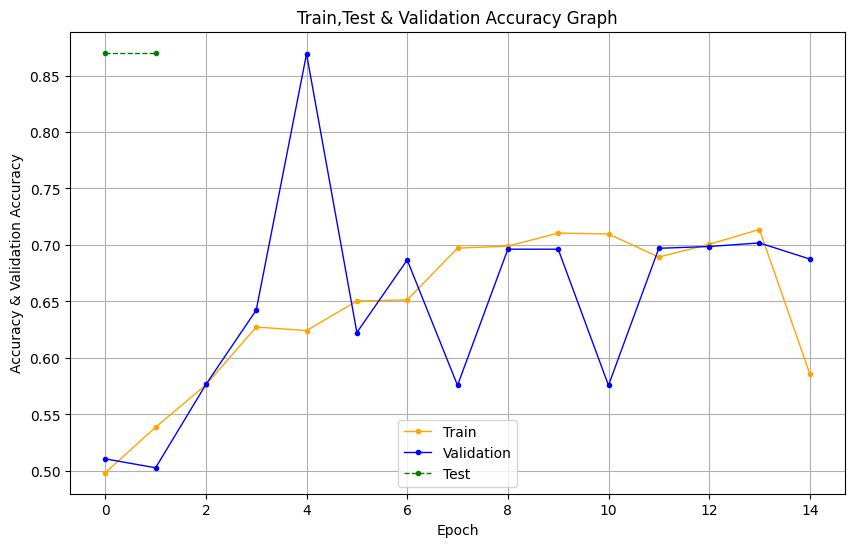

In [ ]:
import matplotlib.pyplot as plt

x_value = test_accuracy

def plot_accuracyGraph(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.history['accuracy'], color = 'orange', linewidth = 1, marker = '.')
  plt.plot(history.history['val_accuracy'], color='blue', linewidth=1, marker='.', label='Validation Accuracy')
  plt.plot([x_value,x_value], color='green', linestyle='dashed', label=f'x = {x_value}', linewidth = 1, marker = '.')
  plt.title('Train,Test & Validation Accuracy Graph')
  plt.ylabel('Accuracy & Validation Accuracy')
  plt.xlabel('Epoch')
  plt.grid(True)
  plt.legend(['Train', 'Validation', 'Test'], loc='lower center')
  plt.show()

plot_accuracyGraph(history)